# Human Activity Recognition using Clustering


**Integrantes:**
- Lucas Carranza
- Guillermo Sánchez
- David Herencia
- José Osnayo

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import glob

## Dataset Analysis

### Lectura de los csv
Leemos los archivos .csv que contienen el id único de cada video, y la clase correspondiente para el entrenamiento y validación.

In [7]:
train_path = "data/train_subset_10.csv"
val_path = "data/val_subset_10.csv"
test_path = "data/test_subset_10.csv"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)
train_df.head()

,youtube_id,label
0,zeIkGEHK46I,riding camel
1,-Fwy8NwefTk,shot put
2,sDD0p8h88rI,dying hair
3,09AinCnKAE8,riding camel
4,qyTDZajMSqQ,baking cookies


### Análisis de Frecuencias

Analizamos las frecuencias de las apariciones de las clases en la data de entrenamiento para saber si requerimos de consideraciones especiales por desbalanceo.

Observamos que la data de validación se encuentra bien balanceada, mientras que la data de entrenamiento no lo está. El ratio de frecuencias entre la clase con más apariciones 'dying hair' y la clase con menos apariciones 'spraying' es de 2.75 a 1 aproximadamente.

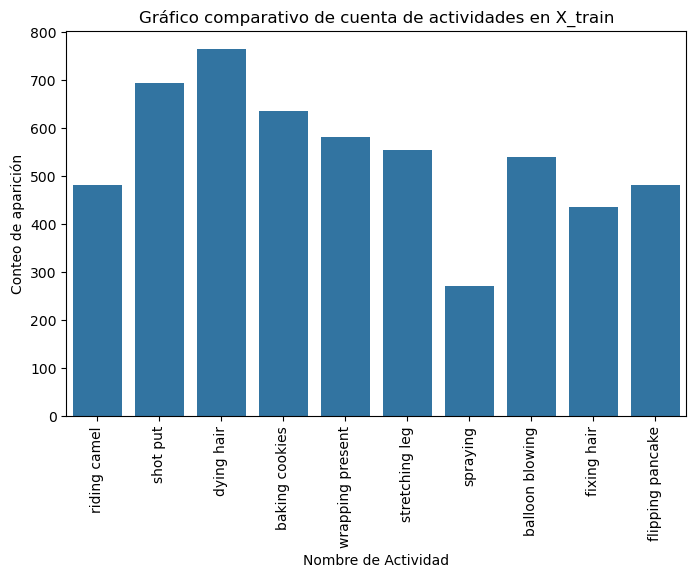

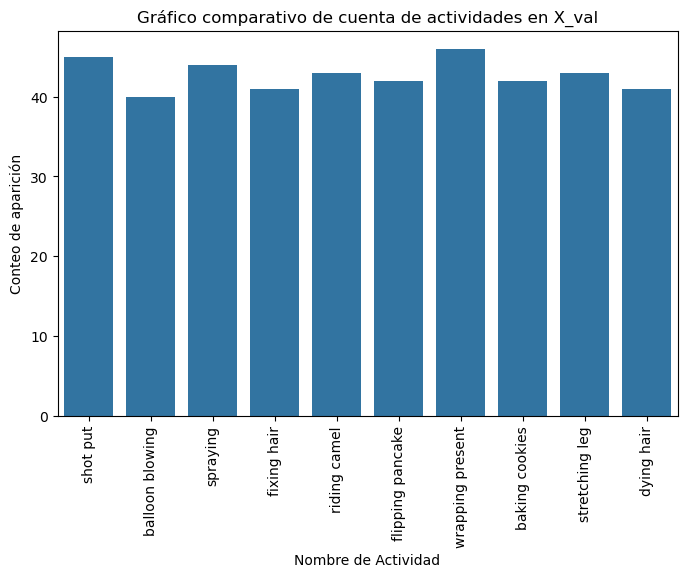

In [12]:
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=train_df)
plt.xticks(rotation='vertical')
plt.title('Gráfico comparativo de cuenta de actividades en X_train')
plt.xlabel('Nombre de Actividad')
plt.ylabel('Conteo de aparición')

plt.figure(figsize=(8,5))
sns.countplot(x='label', data=val_df)
plt.xticks(rotation='vertical')
plt.title('Gráfico comparativo de cuenta de actividades en X_val')
plt.xlabel('Nombre de Actividad')
plt.ylabel('Conteo de aparición')


plt.show()

### Extracción de Features

Utilizamos la librería video_features para extraer el vector característico de cada video, utilizando el modelo R(2+1)D que está especializado en el reconocimiento de actividades.
Para esto necesitamos generar un archivo de texto que contenga las rutas de archivo a cada video a procesar.

In [8]:
# Script para recortar los nombres de cada video a unicamente el id
for directory in ['./data/train_subset', './data/test_subset', './data/val_subset']:
    changed_count = 0
    for filename in os.listdir(directory):
        if filename.endswith(".mp4") and '_' in filename:
            youtube_id = filename.split('_')[0]
            new_filename = f"{youtube_id}.mp4"
            old_file = os.path.join(directory, filename)
            new_file = os.path.join(directory, new_filename)
            
            ''' DESCOMENTAR PARA EJECUTAR CAMBIOS '''
            # os.rename(old_file, new_file) 
            # changed_count += 1
    
    print(f"Renaming process for {directory} completed. Updated {changed_count} file names")

Renaming process for ./data/train_subset completed. Updated 0 file names
Renaming process for ./data/test_subset completed. Updated 0 file names
Renaming process for ./data/val_subset completed. Updated 0 file names


In [9]:
# Script para guardar las rutas de los videos en un archivo .txt
paths = []
directory = '/home/lucas/projects/jupyter_nb/HAClustering/data/'
for youtube_id in train_df['youtube_id']:
    paths.append(os.path.join(directory, f"train_subset/{youtube_id}.mp4"))
for youtube_id in val_df['youtube_id']:
    paths.append(os.path.join(directory, f"val_subset/{youtube_id}.mp4"))
for youtube_id in test_df['youtube_id']:
    paths.append(os.path.join(directory, f"test_subset/{youtube_id}.mp4"))

# write to .txt
output_file = './data/paths.txt'
with open(output_file, 'w') as f:
    for path in paths:
        ''' DESCOMENTAR PARA EJECUTAR CAMBIOS '''
        # f.write(f"{path}\n")

print("Finished writing video paths")

Finished writing video paths


Una vez que ejecutamos el código de la librería video_features y procesamos cada video pot el modelo R(2+1)D, obtenemos una serie de vectores característicos almacenados en un archivo de numpy (.npy), donde cada video tiene su archivo correspondiente. Cada vector característico tiene el formato `{youtube_id}_r21d.npy`.

Leemos y procesamos cada vector característico para almacenarlo en un nuevo dataframe, y eliminamos aquellos vectores que hayan 

In [33]:
feature_path = './feature_vecs/'

def consolidate_features(path, df, return_labels=True):
    features = []
    labels = []
    invalid = 0
    for video in glob.glob(os.path.join(path, '*.npy')):
        youtube_id = os.path.basename(video).split('_')[0]
        current = np.load(video)
        # Skip videos not in df
        if youtube_id not in df['youtube_id'].values:
            continue
        # skip invalid videos
        if current.size == 0:
            invalid += 1
            continue
        features.append(np.mean(current, axis = 0))
        if return_labels:
            labels.append(df[df['youtube_id'] == youtube_id]['label'].values[0])
    print("# Vectores invalidos: ", invalid)
    features = pd.DataFrame(np.vstack(features))
    
    if return_labels:
        labels = pd.DataFrame(np.vstack(labels))
        return features, labels
    else:
        return features
    

X_train, Y_train = consolidate_features(feature_path, train_df)
X_val, Y_val = consolidate_features(feature_path, val_df)
X_test = consolidate_features(feature_path, test_df, return_labels=False)
print("Finished consolidating feature vectors")
X_train.head()

# Vectores invalidos:  1
# Vectores invalidos:  0
# Vectores invalidos:  0
Finished consolidating feature vectors


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,1.494497,0.249047,0.399750,0.679186,0.696014,0.895173,0.293325,0.353114,0.643661,0.707245,...,0.799521,0.381122,0.446890,0.342419,0.880058,0.694818,0.981013,0.295124,0.361455,0.317285
1,0.744264,0.188170,0.817304,0.776127,0.521307,0.569148,0.542938,0.621428,0.503943,0.787819,...,0.652828,1.364401,0.340449,0.459525,0.721002,0.612509,1.315290,1.376368,0.716538,0.645466
2,0.989843,1.018806,0.496407,0.467365,0.789282,1.088436,0.308102,1.604971,1.663163,1.246561,...,0.705443,0.706476,0.458016,1.086126,0.759524,2.203519,1.595214,0.631054,0.599978,0.374537
3,0.625915,0.788936,0.249249,0.395270,0.604471,0.637042,0.415135,1.483415,0.810851,1.367477,...,0.510670,0.953797,1.072413,1.389668,0.670768,1.000817,1.166447,0.478432,0.730390,0.353653
4,0.519893,0.690242,0.427113,0.300980,0.657073,0.643736,0.797343,0.739007,1.545587,1.747996,...,0.367365,0.613456,0.966717,1.746788,0.476944,1.085044,1.380868,0.555157,0.337060,0.551529


In [31]:
print("feature vectors: ", len(X_train) + len(X_val) + len(X_test))
print("csv len:         ", len(train_df) + len(val_df) + len(test_df))

feature vectors:  6645
csv len:          6664


## Reducción de Dimensionalidad

## Implementación

La implementación de los Modelos de Clustering a usar

### Modelo 1

### Modelo 2

## Submission

Archivo .csv para la competencia de Kaggle: https://www.kaggle.com/competitions/project-3-clustering